# Import Libraries

In [1]:
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch

from imblearn.over_sampling import SMOTE

from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [8]:
work_dir = "/home/spaka002/NSF_REU_2024/"

# Get Data

In [9]:
def convert_categorical(df):

    num_c = len(list(df.columns))
    
    for c in range(num_c):
        
        if (type(data.iloc[:, c][0]) != str): continue

        vals = list(set(df.iloc[:, c]))

        t_d = dict()

        for v in range(len(vals)):
            val = vals[v]
            t_d[val] = v

        df.iloc[:, c] = df.iloc[:, c].map(lambda x: t_d[x])
        
    return df

In [10]:
data_folder = f"{work_dir}classification_datasets/"

Undersampled creditcard fraud data

In [11]:
# undersample_amt = 10000

# data = pd.read_csv(f'{data_folder}creditcard.csv')

# negative_indices = list(data[data['Class'] == 0].index)
# random.Random(18).shuffle(negative_indices)

# negatives = np.array(data.iloc[negative_indices[:undersample_amt]])
# positives = np.array(data[data['Class'] == 1])

# dataset = np.concatenate((positives, negatives), axis = 0)
# data_names = list(data.columns)

# del data, negatives, positives, negative_indices

# X = np.array(dataset[:, 1:-1])
# Y = np.array(dataset[:, -1])

# del dataset

Undersampled default creditcard data

In [12]:
# undersample_amt = 15000

# data = pd.read_excel(f"{data_folder}default_creditcard.xls")
# data = data.iloc[1:, 1:]

# indices = list(data[data['Y'] == 0].index)
# random.Random(18).shuffle(indices)

# negatives = np.array(data.iloc[indices[:undersample_amt]])
# positives = np.array(data[data['Y'] == 1])

# dataset = np.concatenate((positives, negatives), axis = 0)
# data_names = list(data.columns)

# del data, negatives, positives

# X = np.array(dataset[:, :-1], dtype = np.float32)
# Y = np.array(dataset[:, -1], dtype = np.uint8)

# del dataset

Particle Identification Dataset

In [13]:
data = np.load(f"{data_folder}MiniBoone_Particle_ID.npy")

X = data[:, :-1]
Y = data[:, -1]

del data

Diabetes Binary Dataset

In [14]:
# data = pd.read_csv(f"{data_folder}diabetes_binary.csv")

# X = np.array(data.iloc[:, 1:])
# Y = np.array(data.iloc[:, 0])

# del data

Biodeg dataset

In [15]:
# data = np.load(f"{data_folder}biodeg.npy")

# X = data[:, :-1]
# Y = data[:, -1]

# del data

Spambase

In [16]:
# data = pd.read_csv(f"{data_folder}spambase.data", 
#                    names = [f"Feature_{i}" for i in range(1, 57)] + ['Target'])

# X = np.array(data.iloc[:, :-1])
# Y = np.array(data.iloc[:, -1])

# del data

Car Evaluation Dataset

In [17]:
# data = pd.read_csv(f"{data_folder}car.data", names = [f"Feature_{i}" for i in range(1, 7)] + ['Target'])
# data = convert_categorical(data)

# X = np.array(data.iloc[:, :-1])
# Y = np.array(data.iloc[:, -1], dtype = np.int8)

# del data

Wine Color Dataset (Very Trivial)

In [18]:
# df1 = pd.read_csv(f"{data_folder}wine/winequality-red.csv",  delimiter=';')
# df1['Color'] = 1

# df2 = pd.read_csv(f"{data_folder}wine/winequality-white.csv",  delimiter=';')
# df2['Color'] = 0

# data = np.concatenate((np.array(df1), np.array(df2)), axis = 0)

# X = data[:, :-1]
# Y = data[:, -1]

# del data, df1, df2

In [19]:
print(f"X Shape: {X.shape}; Y Shape: {Y.shape}")

X Shape: (130064, 50); Y Shape: (130064,)


# Data Pre-Processing

In [20]:
def get_subset(x, y, portion=1, random_state=18):
    
    if (portion>=1): return x, y
    
    X, tx, Y, ty = train_test_split(x, y, test_size=(1-portion), random_state=random_state)
    del tx, ty
    
    return X, Y

In [21]:
X, Y = get_subset(X, Y, 
                  portion=0.01, 
                  random_state=18)

In [22]:
standard_scaler = False

if (standard_scaler):
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

# Looking at the Data

In [23]:
print(f"X Shape: {X.shape}; Y Shape: {Y.shape}")

X Shape: (1300, 50); Y Shape: (1300,)


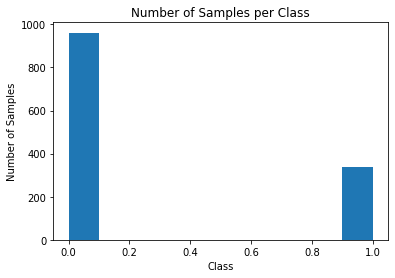

In [24]:
plt.hist(Y)
plt.title("Number of Samples per Class")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.show()

# Get k_fold cross validation result for a given model with a given dataset

In [25]:
def return_eval(model, x, y, n_splits = 5, smote_train=False):
    
    kf = KFold(n_splits=n_splits, shuffle = True, random_state = 18)
        
    overall_metric = 0
    for i, (train_index, test_index) in enumerate(kf.split(x)):

        X_train = x[train_index]
        X_test = x[test_index]
        
        Y_train = y[train_index]
        Y_test = y[test_index]
        
        if (smote_train):
            smote = SMOTE(random_state=18)
            X_train, Y_train = smote.fit_resample(X_train, Y_train)

        
        model.fit(X_train, Y_train)
        preds = model.predict(X_test)
        
        
        # _______ insert evaluation metric ___________________________________
        
        if (len(set(y)) == 2): average = 'binary'
        else: average = 'weighted'
            
        metric_value = f1_score(Y_test, preds, average = average)
        
        # ____________________________________________________________________
        
        overall_metric += metric_value
            
    return (overall_metric/n_splits)

# Testing Classifiers on the Dataset

In [38]:
run_test = True

if (run_test):

#     clf = SVC(C=1.5, 
#               kernel='poly', 
#               degree=5, 
#               gamma='scale', 
#               coef0=1.5, 
#               shrinking=True, 
#               probability=False, 
#               tol=0.001, 
#               cache_size=200, 
#               class_weight=None, 
#               verbose=False, 
#               max_iter=250, 
#               decision_function_shape='ovo', 
#               break_ties=False, 
#               random_state=18)


#     clf = RandomForestClassifier(n_estimators = 25,
#                                  min_samples_split = 2,
#                                  min_impurity_decrease=0.0,
#                                  max_depth = None,
#                                  max_features = None,
#                                  min_samples_leaf = 1,
#                                  criterion = 'gini',
#                                  random_state = 18)


    clf = GradientBoostingClassifier(n_estimators = 50,
                                     min_samples_split = 2,
                                     min_impurity_decrease=0.0,
                                     max_depth = None,
                                     max_features=8,
                                     min_samples_leaf = 1,
                                    #  criterion = 'squared_error',
                                     random_state = 18)

#     clf = KNN(n_neighbors=15, 
#               weights='distance', 
#               algorithm='kd_tree', 
#               leaf_size=30, 
#               p=2, 
#               metric='minkowski', 
#               metric_params=None, 
#               n_jobs=None)
    
        
    # clf = DecisionTreeClassifier(criterion='gini', 
    #                              splitter='best', 
    #                              max_depth=None, 
    #                              min_samples_split=20, 
    #                              min_samples_leaf=1, 
    #                              min_weight_fraction_leaf=0.0, 
    #                              max_features=None, 
    #                              random_state=18, 
    #                              max_leaf_nodes=None, 
    #                              min_impurity_decrease=0.0, 
    #                              class_weight=None, 
    #                              ccp_alpha=0.0)
    

    result = return_eval(model = clf,
                         x = X,
                         y = Y,
                         n_splits = 5,
                         smote_train = False)
    
    print(result)

0.8261312686668252


# Generate Tensor

In [21]:
dim4=[10, 25, 50, 100, 150, 250]
dim3=[2,4,8,16,32,64,128,256]
dim2=[2, 3, 4, 5, 6, 10, None]
dim1=['sqrt', 'log', 1, 3, 5, 7, 9, None]

total_cells = len(dim1)*len(dim2)*len(dim3)*len(dim4)

print(f"({len(dim4)}x{len(dim3)}x{len(dim2)}x{len(dim1)}) tensor output.")
print(f"{total_cells} total combinations.")

(8x8x12x11) tensor output.
8448 total combinations.


In [22]:
def save_tensor(tensor, save_path):
    torch.save(torch.tensor(tensor), save_path)
    print(f"\nSuccessfully saved tensor to \n{save_path}\n")

In [23]:
i=0

tensor_4 = list()
for n_estimators in dim4:
    tensor_3 = list()
    for max_depth in dim3:
        tensor_2 = list()
        for min_samples_leaf in dim2:
            tensor_1 = list()
            for min_samples_split in dim1:
                
                clf = GradientBoostingClassifier(n_estimators = n_estimators,
                                                 min_samples_split = min_samples_split,
                                                 min_impurity_decrease=0.0,
                                                 max_depth = max_depth,
                                                 max_features = None,
                                                 min_samples_leaf = min_samples_leaf,
                                                 criterion = 'squared_error',
                                                 random_state = 18)
                

                result = return_eval(model = clf,
                                     x = X,
                                     y = Y,
                                     n_splits = 5,
                                     smote_train = False)

                i+=1
                if (i%10==0): print(f"{i}/{total_cells} combinations done.")
                tensor_1+= [result]

            tensor_2+= [tensor_1]

        tensor_3+= [tensor_2]
        
    tensor_4+= [tensor_3]
    print(f"\n{len(tensor_4)}/{len(dim4)} 3rd order tensors done.")
    
    save_tensor(tensor_4, 
                save_path = f"{work_dir}meta_datasets/GB_car_evaluation_709.pt")
    
tensor_4 = np.array(tensor_4)

10/8448 combinations done.
20/8448 combinations done.
30/8448 combinations done.
40/8448 combinations done.
50/8448 combinations done.
60/8448 combinations done.
70/8448 combinations done.
80/8448 combinations done.
90/8448 combinations done.
100/8448 combinations done.
110/8448 combinations done.
120/8448 combinations done.
130/8448 combinations done.
140/8448 combinations done.
150/8448 combinations done.
160/8448 combinations done.
170/8448 combinations done.
180/8448 combinations done.
190/8448 combinations done.
200/8448 combinations done.
210/8448 combinations done.
220/8448 combinations done.
230/8448 combinations done.
240/8448 combinations done.
250/8448 combinations done.
260/8448 combinations done.
270/8448 combinations done.
280/8448 combinations done.
290/8448 combinations done.
300/8448 combinations done.
310/8448 combinations done.
320/8448 combinations done.
330/8448 combinations done.
340/8448 combinations done.
350/8448 combinations done.
360/8448 combinations done.
3

2770/8448 combinations done.
2780/8448 combinations done.
2790/8448 combinations done.
2800/8448 combinations done.
2810/8448 combinations done.
2820/8448 combinations done.
2830/8448 combinations done.
2840/8448 combinations done.
2850/8448 combinations done.
2860/8448 combinations done.
2870/8448 combinations done.
2880/8448 combinations done.
2890/8448 combinations done.
2900/8448 combinations done.
2910/8448 combinations done.
2920/8448 combinations done.
2930/8448 combinations done.
2940/8448 combinations done.
2950/8448 combinations done.
2960/8448 combinations done.
2970/8448 combinations done.
2980/8448 combinations done.
2990/8448 combinations done.
3000/8448 combinations done.
3010/8448 combinations done.
3020/8448 combinations done.
3030/8448 combinations done.
3040/8448 combinations done.
3050/8448 combinations done.
3060/8448 combinations done.
3070/8448 combinations done.
3080/8448 combinations done.
3090/8448 combinations done.
3100/8448 combinations done.
3110/8448 comb


KeyboardInterrupt



In [ ]:
print(np.round(tensor_4, 4))

In [ ]:
if (0):
    save_path = f"{work_dir}meta_datasets/GB_biodeg_707.pt"
    save_tensor(tensor_4, save_path = save_path)
    print(f"Successfully saved tensor to \n{save_path}")